In [36]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import tensorflow as tf
from keras import layers, Input, Model

plt.rcParams['figure.figsize'] = [15, 6]

In [37]:
IMAGE_SIZE = 128

INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
BLANK_IMAGE = np.zeros(INPUT_SHAPE, np.uint8)
BLANK_IMAGE[:,:] = (255, 255, 255)

In [38]:
root = 'data/'
folders = [f.path for f in os.scandir(root) if f.is_dir()]

folders

['data/dogs',
 'data/cats',
 'data/bike',
 'data/flowers',
 'data/horses',
 'data/cars',
 'data/human']

In [39]:
def draw_random(images, labels = None):
      total = len(images)
    
      for local_index, global_index in enumerate(np.random.randint(0, total, 10)):
            image = images[global_index]
            label = global_index if labels is None else labels[global_index]
        
            plt.subplot(2, 5, local_index + 1)
            plt.imshow(image, cmap='gray', vmin=0, vmax=255)
            plt.axis(False)
            plt.title(label)

In [40]:
def resize_image(image):
    original_height, original_width = image.shape[:2]
    aspect = original_width / original_height

    width = IMAGE_SIZE
    height = IMAGE_SIZE
    height_offset = 0
    width_offset = 0

    if aspect > 1:
        height = int(np.round(IMAGE_SIZE / aspect))
        height_offset = int(np.round((IMAGE_SIZE - height) / 2))

    if aspect < 1:
        width = int(np.round(IMAGE_SIZE * aspect))
        width_offset = int(np.round((IMAGE_SIZE - width) / 2))

    image = cv2.resize(image, (width, height))
    
    if aspect == 1:
        return image
    
    new_image = BLANK_IMAGE.copy()
    new_image[height_offset:height_offset+height, width_offset:width_offset+width] = image.copy()

    return new_image

In [41]:
def load_images(folders = [], training = 0.8):
      images = []

      for folder in folders:
            fnames = os.listdir(folder)

            for fname in fnames:
                  original_image = cv2.imread(os.path.join(folder, fname))
                  original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
                  resized_image = resize_image(original_image)

                  images.append(resized_image)

      np.random.shuffle(images)
      
      total = len(images)
      offset = int(total * training)
      
      training_images = images[:offset]
      testing_images = images[offset:]
      
      return training_images, testing_images, total

In [42]:
training_images, testing_images, total = load_images(folders, training = 0.8)

len(training_images), len(testing_images), total

(1442, 361, 1803)

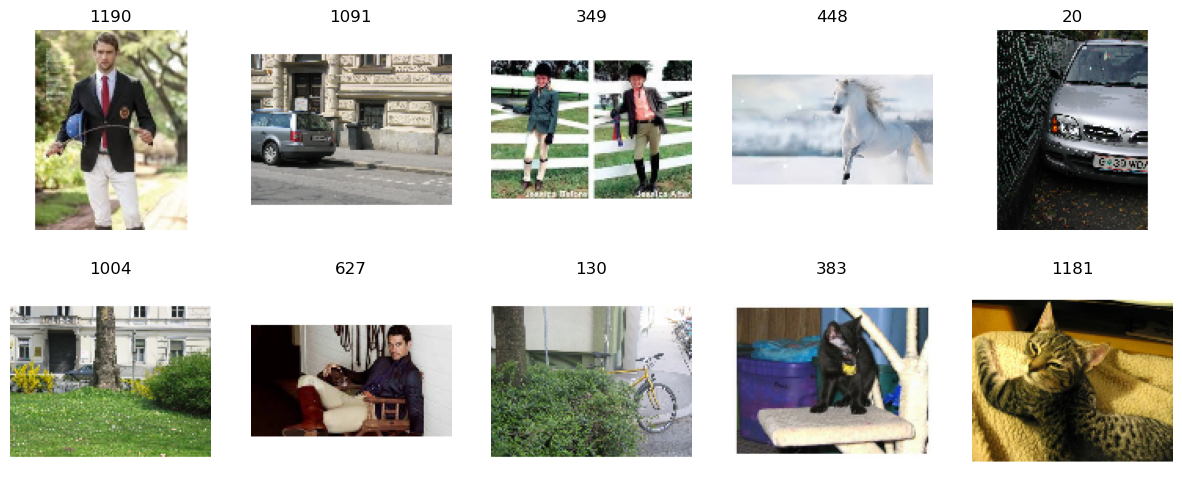

In [43]:
draw_random(training_images)

In [44]:
def gaussian_noise(image, mean = 0, stddev = 10, gamma = 1):
    gauss_noise = np.zeros(image.shape[:2])

    cv2.randn(gauss_noise, mean, stddev)

    gauss_noise = (gauss_noise * gamma).astype(np.uint8)
    
    merged = cv2.merge([gauss_noise] * 3)
    output = cv2.add(image, merged)

    return output

In [45]:
def salt_pepper_noise(image, prob = 0.5):
    output = image.copy()

    black = np.array([0, 0, 0], dtype='uint8')
    white = np.array([255, 255, 255], dtype='uint8')
    probs = np.random.random(output.shape[:2])

    output[probs < (prob / 2)] = black
    output[probs > 1 - (prob / 2)] = white

    return output

In [46]:
def uniform_noise(image, gamma = 1):
      uni_noise = np.zeros(image.shape[:2])
      cv2.randu(uni_noise, 0, 256)
      uni_noise = (uni_noise * gamma).astype(np.uint8)
      merged = cv2.merge([uni_noise, uni_noise, uni_noise])
      output = cv2.add(image, merged)
    
      return output

In [47]:
def add_noise_to_image(image):
    noise_type = np.random.randint(3) # 0: Gaussian, 1: Salt and Pepper, 2: Uniform
    
    if noise_type == 0:
        return gaussian_noise(image)
    
    if noise_type == 1:
        return salt_pepper_noise(image)
    
    return uniform_noise(image)

In [48]:
def add_noise_to_images(images):
    return [add_noise_to_image(image) for image in images]

In [49]:
noised_training_images = add_noise_to_images(training_images)

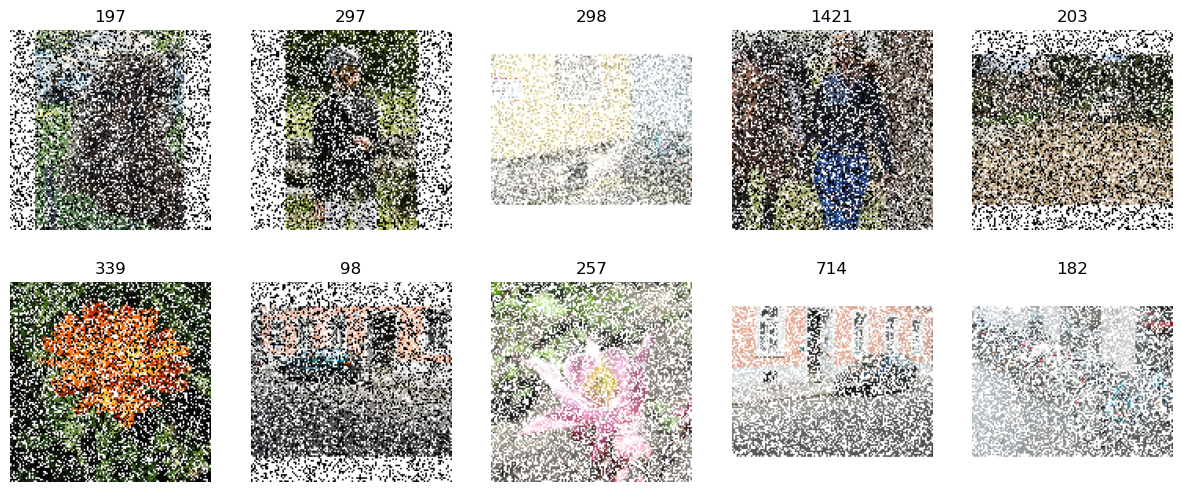

In [50]:
draw_random(noised_training_images)

In [51]:
def normalize_images(images):
      return np.array([image / 255 for image in images])

In [52]:
def make_data_for_model(noise_images, original_images):
      noise_images, original_images = shuffle(noise_images, original_images)
      noise_images_normalized = normalize_images(noise_images)
      original_images_normalized = normalize_images(original_images)
      noise_images_input_tensor = tf.convert_to_tensor(noise_images_normalized)
      original_images_input_tensor = tf.convert_to_tensor(original_images_normalized)

      return noise_images_input_tensor, original_images_input_tensor

In [63]:
noised_images_to_train, original_images_to_train = make_data_for_model(noised_training_images, training_images)

noised_images_to_train.shape, original_images_to_train.shape

(TensorShape([1442, 128, 128, 3]), TensorShape([1442, 128, 128, 3]))

In [64]:
noised_testing_images = add_noise_to_images(testing_images)

In [66]:
noised_images_to_test, original_images_to_test = make_data_for_model(noised_testing_images, testing_images)

noised_images_to_test.shape, original_images_to_test.shape

(TensorShape([361, 128, 128, 3]), TensorShape([361, 128, 128, 3]))

In [70]:
input = Input(shape=INPUT_SHAPE)

x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 64, 64, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 128, 128, 32)   │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,507 (115.26 KB)

 Trainable params: 29,507 (115.26 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
autoencoder.fit(
    x=noised_images_to_train,
    y=original_images_to_train,
    epochs=50,
    batch_size=50,
    shuffle=True,
    validation_data=(original_images_to_test, original_images_to_test),
)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - loss: 0.6823 - val_loss: 0.6046
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - loss: 0.6115 - val_loss: 0.5345
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - loss: 0.5773 - val_loss: 0.5272
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - loss: 0.5538 - val_loss: 0.5025
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - loss: 0.5402 - val_loss: 0.4840
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - loss: 0.5218 - val_loss: 0.4816
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - loss: 0.5133 - val_loss: 0.4756
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - loss: 0.5019 - val_loss: 0.4725
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - loss: 0.4855 - val_loss: 0.4717
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - loss: 0.4827 - val_loss: 0.4722
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - loss: 0.4761 - val_loss: 0.4739
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step

In [ ]:
predictions = autoencoder.predict(noised_images_to_test)

# display_prediction(noisy_test_data, predictions) # TODO: write tomorrow
